# Predicción de Lluvia en Australia

### Facultad de Ciencias Exactas, Ingeniería y Agrimensura  
### Tecnicatura en Inteligencia Artificial  
### Aprendizaje Automático 1  

**Trabajo Práctico**: Predicción de lluvia utilizando modelos de clasificación y redes neuronales.

**Autores**:  
- Avecilla Tomas 
- Calcia Franco  

 

---

### Objetivo
Desarrollar un modelo de predicción de la variable `RainTomorrow` basado en datos climáticos de Australia, utilizando técnicas de pre-procesamiento, modelado, evaluación y optimización de modelos, para su posterior puesta en producción.



### Diccionario de Datos

| Variable         | Descripción                                                       | Tipo        | Ejemplo       
|-------------------|------------------------------------------------------------------|-------------|---------------
| **Date**          | Fecha de la observación del clima.                               | object      | 2010-01-01    
| **Location**      | Ciudad donde se realizó la medición del clima.                  | object      | Sydney        
| **MinTemp**       | Temperatura mínima del día (en grados Celsius).                 | float64     | 12.3          
| **MaxTemp**       | Temperatura máxima del día (en grados Celsius).                 | float64     | 28.9          
| **Rainfall**      | Cantidad de lluvia caída en milímetros durante el día.          | float64     | 0.0           
| **Evaporation**   | Evaporación en milímetros durante el día.                       | float64     | 0.0           
| **Sunshine**      | Horas de sol durante el día.                                    | float64     | 8.0           
| **WindGustDir**   | Dirección del viento racheado (en grados).                      | object      | NNE           
| **WindGustSpeed** | Velocidad del viento racheado (en km/h).                        | float64     | 15.0          
| **WindDir9am**    | Dirección del viento a las 9 am.                                | object      | NNE           
| **WindDir3pm**    | Dirección del viento a las 3 pm.                                | object      | SSE          
| **WindSpeed9am**  | Velocidad del viento a las 9 am (en km/h).                     | float64     | 5.0           
| **WindSpeed3pm**  | Velocidad del viento a las 3 pm (en km/h).                     | float64     | 10.0          
| **Humidity9am**   | Humedad relativa a las 9 am (%).                               | float64     | 65.0          
| **Humidity3pm**   | Humedad relativa a las 3 pm (%).                               | float64     | 55.0          
| **Pressure9am**   | Presión atmosférica a las 9 am (hPa).                          | float64     | 1012.0        
| **Pressure3pm**   | Presión atmosférica a las 3 pm (hPa).                          | float64     | 1011.0        
| **Cloud9am**      | Cobertura nubosa a las 9 am (en octavos).                      | float64     | 2.0           
| **Cloud3pm**      | Cobertura nubosa a las 3 pm (en octavos).                      | float64     | 3.0           
| **Temp9am**       | Temperatura a las 9 am (en grados Celsius).                    | float64     | 15.0          
| **Temp3pm**       | Temperatura a las 3 pm (en grados Celsius).                    | float64     | 20.0          
| **RainToday**     | Indica si llovió hoy (Yes/No).                                 | object      | Yes           
| **RainTomorrow** _(Target)_ | Indica si lloverá mañana (Yes/No).                             | object      | No            


## Preparación del entorno de trabajo

In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier

In [394]:
df_clima = pd.read_csv("weatherAUS.csv")

## Análisis Descriptivo

In [395]:
df_clima.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [396]:
# Resumen de estadísticas descriptivas
stats = df_clima.describe().T
stats['missing_values'] = df_clima.isnull().sum()
stats = stats.round(2)
stats.head(35)


,count,mean,std,min,25%,50%,75%,max,missing_values
MinTemp,143975.0,12.19,6.40,-8.5,7.6,12.0,16.9,33.9,1485
MaxTemp,144199.0,23.22,7.12,-4.8,17.9,22.6,28.2,48.1,1261
Rainfall,142199.0,2.36,8.48,0.0,0.0,0.0,0.8,371.0,3261
Evaporation,82670.0,5.47,4.19,0.0,2.6,4.8,7.4,145.0,62790
Sunshine,75625.0,7.61,3.79,0.0,4.8,8.4,10.6,14.5,69835
WindGustSpeed,135197.0,40.04,13.61,6.0,31.0,39.0,48.0,135.0,10263
WindSpeed9am,143693.0,14.04,8.92,0.0,7.0,13.0,19.0,130.0,1767
WindSpeed3pm,142398.0,18.66,8.81,0.0,13.0,19.0,24.0,87.0,3062
Humidity9am,142806.0,68.88,19.03,0.0,57.0,70.0,83.0,100.0,2654
Humidity3pm,140953.0,51.54,20.80,0.0,37.0,52.0,66.0,100.0,4507


**Descripción rápida de los datos:**
Este conjunto de datos contiene información meteorológica con un número considerable de valores faltantes. Algunas variables como la evaporación, la luz solar y la cobertura nubosa tienen un porcentaje elevado de datos faltantes, mientras que otras, como la temperatura y la humedad, tienen menos valores nulos.

In [397]:
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

El DataFrame contiene 145,460 registros y 23 columnas, de las cuales 16 son de tipo numérico (float64) y 7 de tipo categórico (object). Como primer paso, convertiremos el tipo de dato de la columna 'Date' a un formato de fecha adecuado y luego ordenaremos el dataset en orden ascendente.

In [398]:
df_clima['Date'] = pd.to_datetime(df_clima['Date'])

df_clima = df_clima.sort_values(by='Date', ascending=True)

In [399]:

df_clima = pd.get_dummies(df_clima, columns=['RainToday', 'RainTomorrow'], drop_first=True)
# Renombrar las columnas
df_clima = df_clima.rename(columns={'RainToday_Yes': 'RainToday', 'RainTomorrow_Yes': 'RainTomorrow'})


Vamos a analizar el comportamiento de nuestras variables numéricas para identificar tendencias o distribuciones. 

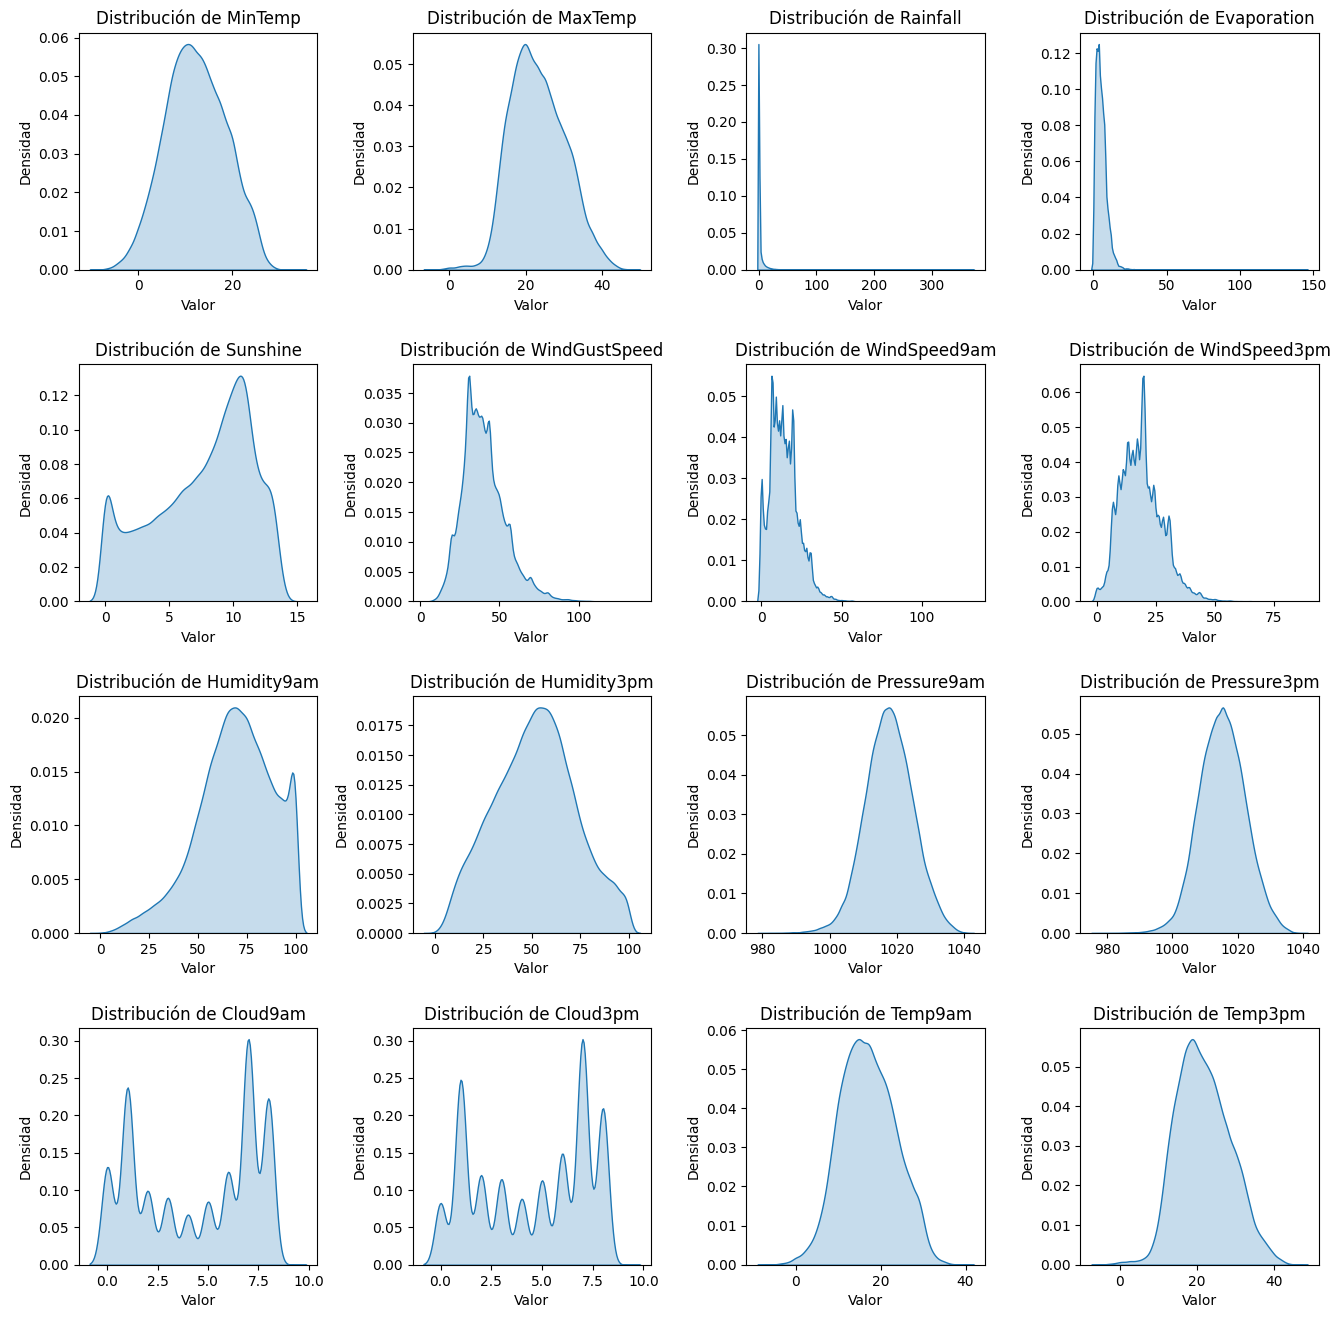

In [400]:
# Filtrar las columnas numéricas del dataframe
df_numerico = df_clima.select_dtypes(include=['float64', 'int64'])

# Determinar el número de variables numéricas
num_vars = len(df_numerico.columns)

# Configurar la figura y las subplots
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))

# Ajustar espacio entre los gráficos
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Recorrer las columnas y plotear cada una en su propio subplot
for i, column in enumerate(df_numerico.columns):
    row, col = divmod(i, 4)
    sns.kdeplot(df_numerico[column], ax=axes[row, col], fill=True)
    axes[row, col].set_title(f'Distribución de {column}')
    axes[row, col].set_xlabel('Valor')
    axes[row, col].set_ylabel('Densidad')

# Eliminar gráficos vacíos si no se llena la última fila
for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()


Al analizar las distribuciones de las variables numéricas a través de gráficos de KDE, observamos varios patrones.

1. **Distribuciones Normales**:
   Algunas variables muestran una distribución simétrica, similar a la curva de campana característica de la **distribución normal**.

2. **Distribuciones Asimétricas (Sesgo)**:
   Otras variables presentan **sesgo**, ya sea positivo o negativo..
   
   - **Implicación**: Estas variables pueden requerir transformaciones para mejorar su simetría. Esto facilitará la aplicabilidad para los modelos.

3. **Distribuciones Multimodales**:
   Se observan algunas variables con **distribuciones multimodales**, es decir, con varios picos en su densidad. Esto podría sugerir la existencia de **subgrupos** lo cual es normal ya que los datos son climaticos y puede llegar a tener algo que ver con las estaciones.

4. **Presencia de Outliers**:
   Varias variables muestran distribuciones con **colas largas**, lo que indica la presencia de **outliers** lo cual nos confirma lo que fue analizado anteriormente.



## Analisis exploratorio

Viendo que las columnas 'WindGustDir', 'WindDir9am' y 'WindDir3pm' son variables categóricas (tipo object), evaluaremos su correlación con nuestra variable objetivo. Esto nos ayudará a decidir si es conveniente eliminarlas o mantenerlas, con el objetivo de reducir la complejidad del modelo y evitar posibles problemas en la etapa de predicción.

C:\Users\franco\AppData\Local\Temp\ipykernel_12840\12744194.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_with_rain.index, y=correlations_with_rain.values, palette='coolwarm')


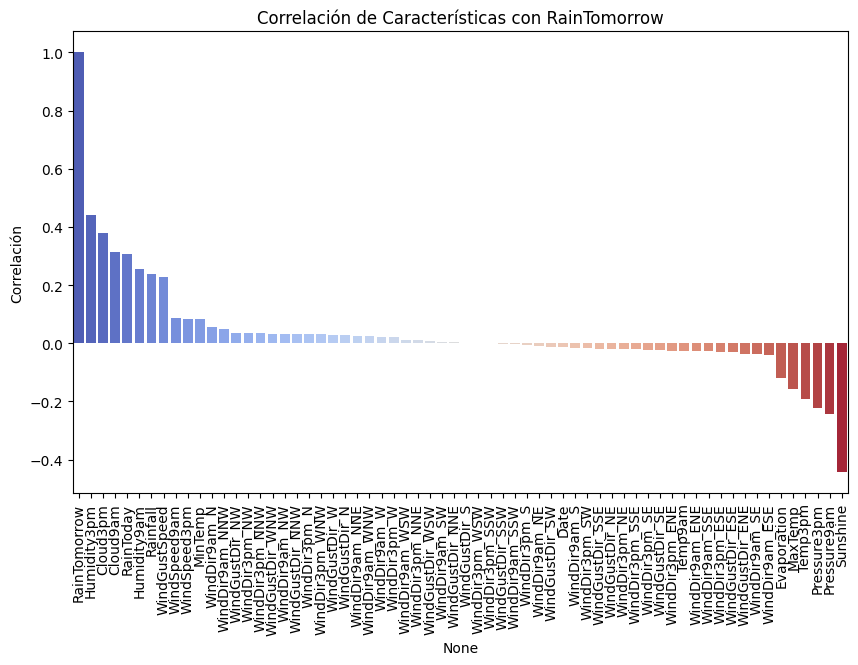

In [401]:
# Eliminar la columna 'Location'
df_without_location = df_clima.drop(columns=['Location'])
# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df_without_location, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm'], drop_first=True)

# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Mostrar correlación con 'RainTomorrow'
# Ordenar las correlaciones con 'RainTomorrow'
correlations_with_rain = correlation_matrix['RainTomorrow'].sort_values(ascending=False)

# Crear un gráfico de barras para visualizar la correlación de cada característica con 'RainTomorrow'
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_with_rain.index, y=correlations_with_rain.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Correlación de Características con RainTomorrow')
plt.ylabel('Correlación')
plt.show()

Es evidente que estas variables no tendrían un impacto significativo en el rendimiento del modelo. Por lo tanto, procederemos a eliminarlas para simplificar el conjunto de datos y evitar complicaciones en el proceso de predicción.

In [402]:
columnas = ['WindDir9am', 'WindDir3pm', 'WindGustDir']

# Dropear las columnas
df_clima = df_clima.drop(columns=columnas)

Para la variable categórica 'Location', calculamos la proporción de cada localidad en relación con nuestra variable objetivo. Esto nos permitió evaluar cómo cada ubicación podría influir en la predicción.

In [403]:
df_clima['Location'] = df_clima['Location'].fillna('Categoria_Nula')

mean_encoded_location_today = df_clima.groupby('Location')['RainTomorrow'].mean()

df_clima['Location'] = df_clima['Location'].map(mean_encoded_location_today)

Al observar los valores faltantes, calculamos el porcentaje de datos faltantes en cada columna. 

In [404]:
conteo_nan = df_clima.isnull().sum()
# Que porcentaje del total de cada columna hay valores faltantes
nan_percentage = (conteo_nan / len(df_clima)) * 100
missing_data = pd.DataFrame({'count': conteo_nan, 'percentage': nan_percentage})
print(missing_data)

               count  percentage
Date               0    0.000000
Location           0    0.000000
MinTemp         1485    1.020899
MaxTemp         1261    0.866905
Rainfall        3261    2.241853
Evaporation    62790   43.166506
Sunshine       69835   48.009762
WindGustSpeed  10263    7.055548
WindSpeed9am    1767    1.214767
WindSpeed3pm    3062    2.105046
Humidity9am     2654    1.824557
Humidity3pm     4507    3.098446
Pressure9am    15065   10.356799
Pressure3pm    15028   10.331363
Cloud9am       55888   38.421559
Cloud3pm       59358   40.807095
Temp9am         1767    1.214767
Temp3pm         3609    2.481094
RainToday          0    0.000000
RainTomorrow       0    0.000000


Algunas variables, como 'Evaporation', 'Sunshine' y 'Cloud3pm', tienen un porcentaje considerable de datos faltantes, llegando casi el 50%, mientras que otras, como 'MinTemp' y 'MaxTemp', presentan menos del 1.1% de datos faltantes.

### Limpieza de Datos

Como primera medida, eliminaremos las filas que tengan valores nulos en la variable objetivo o aquellas que presenten 18 o más columnas con valores nulos, ya que las consideramos irrelevantes para el análisis.

In [405]:
#Mantenemos las filas que contengan 18 o menos valores nulos
df_clima = df_clima.dropna(thresh=18)

#Eliminamos las filas que contienen la variable Target como nula
df_clima = df_clima.dropna(subset=['RainTomorrow'])

A continuación, realizaremos la división de los datos, ya que consideramos que es un paso necesario en este punto. Sin embargo, continuaremos con el análisis exploratorio y la limpieza de los datos una vez realizada esta división.

### Train-Test

In [406]:
X_train, X_test, y_train, y_test = train_test_split(df_clima.drop(columns=['RainTomorrow']), df_clima['RainTomorrow'], test_size=0.3, random_state=42)

#Validacion
X_train, X_temp, y_train, y_temp = train_test_split(
    df_clima.drop(columns=['RainTomorrow']),
    df_clima['RainTomorrow'],
    test_size=0.3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5, 
    random_state=42
)

# Concatenar para tener dataframes completos
df_entrenamiento = pd.concat([X_train, y_train], axis=1)
df_validacion = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

Decidimos imputar las variables que tienen menos de 1000 valores faltantes utilizando la media, ya que el porcentaje que representan en relación con el total de filas es insignificante y no debería afectar el análisis o los resultados del modelo de manera considerable.

In [407]:
# Identificar las columnas con menos de 1000 nulos
cols_with_few_nans = df_entrenamiento.columns[df_entrenamiento.isnull().sum() < 1000]
medias = {}

for col in cols_with_few_nans:
    if df_entrenamiento[col].dtype in ['float64', 'int64']:  # Solo columnas numéricas
        media = df_entrenamiento[col].mean()  # Calcular la media
        df_entrenamiento[col] = df_entrenamiento[col].fillna(media) 
        medias[col] = media


In [408]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
Evaporation       7212
Sunshine         10481
WindGustSpeed     2867
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am          4674
Cloud3pm          5780
Temp9am              0
Temp3pm              0
RainToday            0
RainTomorrow         0
dtype: int64

Todavia contamos con columnas que presentan una cantidad considerable de valores nulos. Antes de tomar decisiones sobre cómo manejarlas, analizaremos su distribución para evaluar si es conveniente imputarlas o eliminarlas, con el fin de tomar una decisión informada que no afecte negativamente el análisis o el rendimiento del modelo.

<Axes: xlabel='Evaporation', ylabel='Density'>

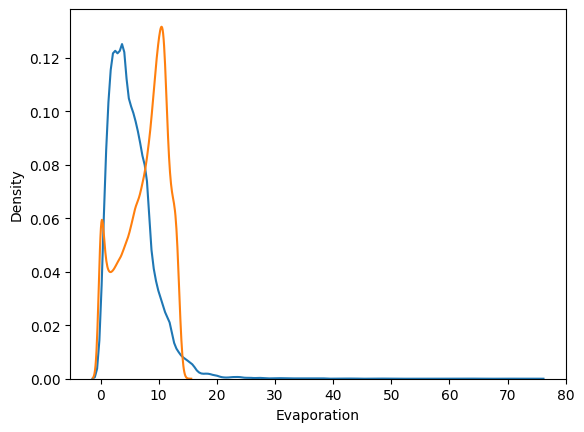

In [409]:
sns.kdeplot(df_entrenamiento["Evaporation"])
sns.kdeplot(df_entrenamiento["Sunshine"])

Podemos observar una clara distribución asimétrica a la derecha. Por lo tanto, optaremos por imputar los valores nulos utilizando la mediana, ya que este enfoque es más robusto frente a los valores atípicos y proporciona una estimación más representativa de los datos.

In [410]:
# Imputar los valores faltantes en 'Evaporation' y 'Sunshine' con la mediana
mediana_evaporation = df_entrenamiento['Evaporation'].median()
mediana_sunshine= df_entrenamiento['Sunshine'].median()

df_entrenamiento['Evaporation'] = df_entrenamiento['Evaporation'].fillna(mediana_evaporation)
df_entrenamiento['Sunshine'] = df_entrenamiento['Sunshine'].fillna(mediana_sunshine)


Aplicamos lo mismo para las demás columnas.

<Axes: xlabel='Cloud3pm', ylabel='Density'>

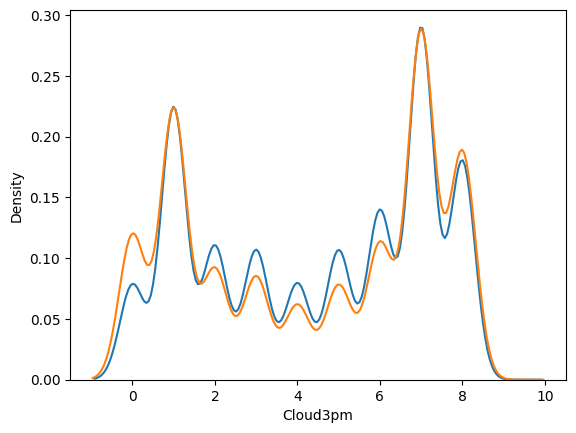

In [411]:
sns.kdeplot(df_entrenamiento["Cloud3pm"])
sns.kdeplot(df_entrenamiento["Cloud9am"])

Debido a la presencia de valores extremos en nuestras variables, decidimos utilizar la mediana para la imputación de datos nulos, ya que este enfoque proporciona una representación más confiable del 'valor central' y minimiza la influencia de los outliers en los resultados.

In [412]:
# Calcular la mediana en lugar de la media móvil en el conjunto de entrenamiento
cloud9am_median = df_entrenamiento['Cloud9am'].median()
cloud3pm_median = df_entrenamiento['Cloud3pm'].median()

df_entrenamiento['Cloud9am'] = df_entrenamiento['Cloud9am'].fillna(cloud9am_median)
df_entrenamiento['Cloud3pm'] = df_entrenamiento['Cloud3pm'].fillna(cloud3pm_median)

<Axes: xlabel='Cloud3pm', ylabel='Density'>

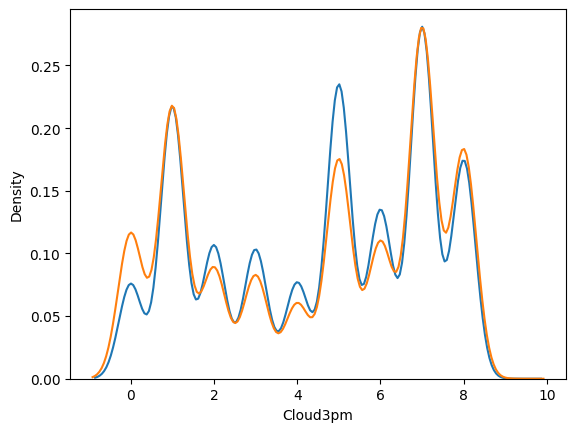

In [413]:
sns.kdeplot(df_entrenamiento["Cloud3pm"])
sns.kdeplot(df_entrenamiento["Cloud9am"])

In [414]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustSpeed    2867
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
dtype: int64

Por último, realizaremos un análisis de la variable 'WindGustSpeed'.

In [415]:
df_entrenamiento["WindGustSpeed"].describe()

count    58476.000000
mean        40.683990
std         13.466982
min          9.000000
25%         31.000000
50%         39.000000
75%         48.000000
max        124.000000
Name: WindGustSpeed, dtype: float64

Elegimos la mediana para imputar los valores nulos de esta variable porque la desviación estándar (13.47) es alta en comparación con la media (40.68), lo que indica variabilidad y la posible presencia de valores atípicos. La mediana (39) es menos sensible a estos extremos y proporciona un valor central más representativo para la variable.

In [416]:
median_WindGustSpeed = df_entrenamiento['WindGustSpeed'].median()
df_entrenamiento['WindGustSpeed'] = df_entrenamiento['WindGustSpeed'].fillna(median_WindGustSpeed)

In [417]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

#### Outliers

In [418]:
resultados_atipicos = {}

for columna in df_entrenamiento.columns:
    if df_entrenamiento[columna].dtype in ['int64', 'float64']:
        Q1 = df_entrenamiento[columna].quantile(0.25)
        Q3 = df_entrenamiento[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_entrenamiento[columna] < limite_inferior) | (df_entrenamiento[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_entrenamiento)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: Location - Porcentaje de valores atípicos: 0.00%
Columna: MinTemp - Porcentaje de valores atípicos: 0.02%
Columna: MaxTemp - Porcentaje de valores atípicos: 0.03%
Columna: Rainfall - Porcentaje de valores atípicos: 17.84%
Columna: Evaporation - Porcentaje de valores atípicos: 3.24%
Columna: Sunshine - Porcentaje de valores atípicos: 0.00%
Columna: WindGustSpeed - Porcentaje de valores atípicos: 2.22%
Columna: WindSpeed9am - Porcentaje de valores atípicos: 1.78%
Columna: WindSpeed3pm - Porcentaje de valores atípicos: 1.85%
Columna: Humidity9am - Porcentaje de valores atípicos: 0.97%
Columna: Humidity3pm - Porcentaje de valores atípicos: 0.00%
Columna: Pressure9am - Porcentaje de valores atípicos: 0.99%
Columna: Pressure3pm - Porcentaje de valores atípicos: 0.80%
Columna: Cloud9am - Porcentaje de valores atípicos: 0.00%
Columna: Cloud3pm - Porcentaje de valores atípicos: 0.00%
Columna: Temp9am - Porcentaje de valores atípicos: 0.02%
Columna: Temp3pm - Porcentaje de valores atípi

Observamos que en la mayoría de las columnas no hay una cantidad significativa de valores atípicos, por lo que decidimos no realizar ningún tratamiento sobre ellos.

A continuación, analizaremos la distribución de la variable objetivo.

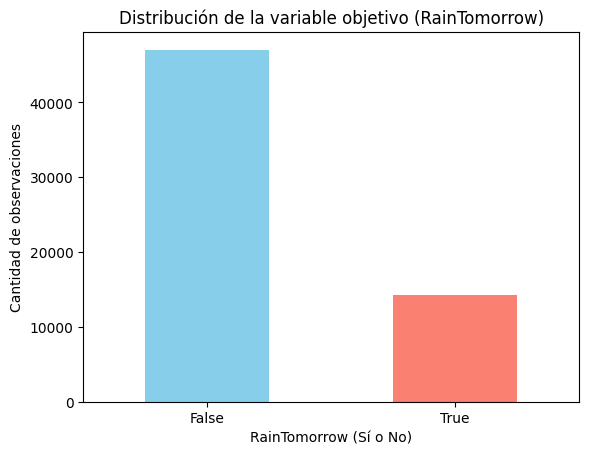

In [419]:
df_entrenamiento['RainTomorrow'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Distribución de la variable objetivo (RainTomorrow)')
plt.xlabel('RainTomorrow (Sí o No)')
plt.ylabel('Cantidad de observaciones')
plt.xticks(rotation=0)
plt.show()


Observamos una marcada diferencia entre los dos valores de la variable objetivo, lo que indica que el conjunto de datos **está desbalanceado**. Además, es importante analizar la tasa de aciertos en las predicciones del dataset.

Predicción Acertada
True     39151
False    22192
Name: count, dtype: int64


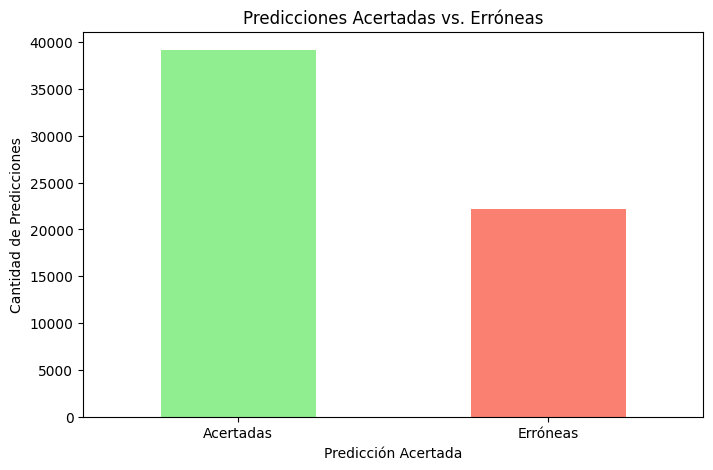

In [420]:
# Crear una copia de las columnas relevantes
df_aciertos = df_entrenamiento[['RainToday', 'RainTomorrow']].copy()

# Comparar RainToday de la fila actual con RainTomorrow de la fila anterior
# shift() mueve la columna RainTomorrow una fila hacia abajo
df_aciertos['Predicción Acertada'] = df_aciertos['RainToday'] == df_aciertos['RainTomorrow'].shift(1)

# Contar las predicciones acertadas y erróneas
conteo_aciertos = df_aciertos['Predicción Acertada'].value_counts()

# Mostrar conteo de aciertos
print(conteo_aciertos)

# Graficar los resultados
plt.figure(figsize=(8, 5))
conteo_aciertos.plot(kind='bar', color=['lightgreen', 'salmon'])

plt.title('Predicciones Acertadas vs. Erróneas')
plt.xlabel('Predicción Acertada')
plt.ylabel('Cantidad de Predicciones')
plt.xticks(ticks=[0, 1], labels=['Acertadas', 'Erróneas'], rotation=0)

plt.show()


Considerando la información proporcionada por las variables, analizamos la precisión de las 'predicciones' sobre si lloverá mañana. Observamos que se ha logrado una predicción con cierto grado de efectividad, aunque hay margen para mejorar.

### Matriz de correlación


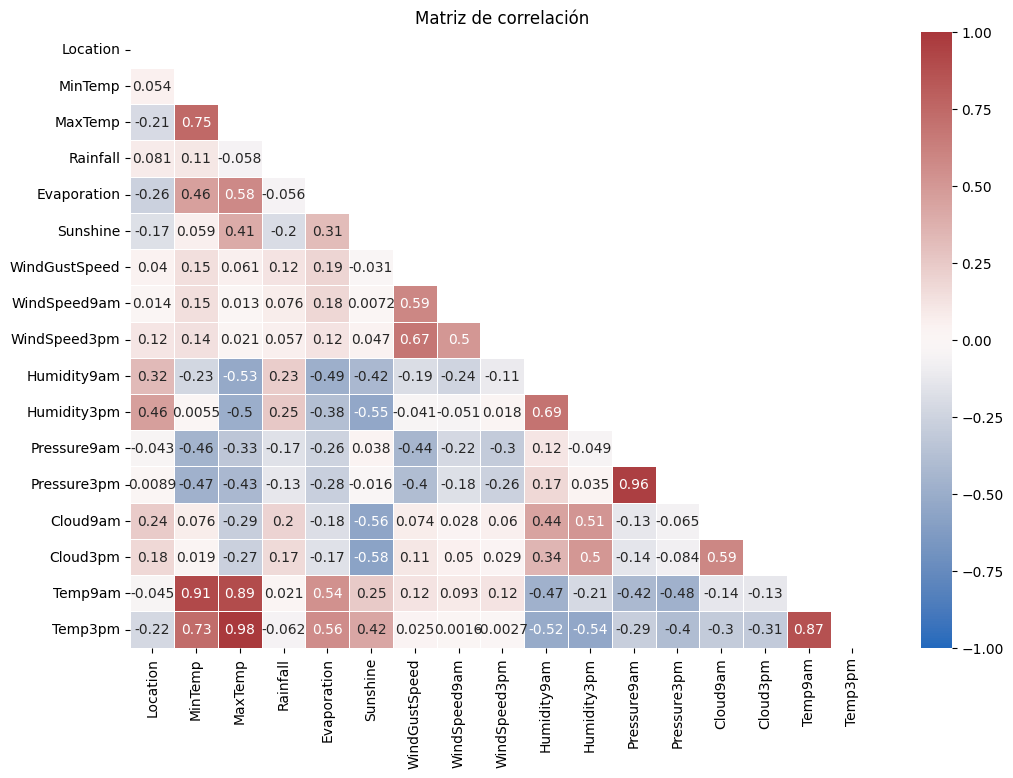

In [421]:
df_numerico = df_entrenamiento.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
corr_matrix = df_numerico.corr()

# Crear la máscara
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear el colormap
colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Graficar el heatmap de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()


Decidimos eliminar las columnas 'Temp9am' y 'Temp3pm', ya que contamos con 'MinTemp' y 'MaxTemp' para todo el día, y su correlación sugiere que son redundantes. De manera similar, considerando la correlación entre 'Pressure9am' y 'Pressure3pm', optamos por conservar solo una de ellas.

In [422]:
df_entrenamiento = df_entrenamiento.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])

### Limpieza de datos para df_test y df_validacion

Todas las imputaciones y limpiezas de datos que realizamos para el conjunto de entrenamiento también se aplicarán a los conjuntos de prueba y validación, asegurando consistencia en el procesamiento de los datos.

In [423]:
for col, media in medias.items():
    if col in df_validacion.columns:   
        df_validacion[col] = df_validacion[col].fillna(media)  
for col, media in medias.items():
    if col in df_test.columns:  
        df_test[col] = df_test[col].fillna(media)


df_test["Evaporation"] = df_test["Evaporation"].fillna(mediana_evaporation)
df_test["Sunshine"] = df_test["Sunshine"].fillna(mediana_sunshine)
df_validacion["Evaporation"] = df_validacion["Evaporation"].fillna(mediana_evaporation)
df_validacion["Sunshine"] = df_validacion["Sunshine"].fillna(mediana_sunshine)


df_test['Cloud9am'] = df_test['Cloud9am'].fillna(cloud9am_median)
df_test['Cloud3pm'] = df_test['Cloud3pm'].fillna(cloud3pm_median)
df_validacion['Cloud9am'] = df_validacion['Cloud9am'].fillna(cloud9am_median)
df_validacion['Cloud3pm'] = df_validacion['Cloud3pm'].fillna(cloud3pm_median)

df_test['WindGustSpeed'] = df_test['WindGustSpeed'].fillna(median_WindGustSpeed)
df_validacion['WindGustSpeed'] = df_validacion['WindGustSpeed'].fillna(median_WindGustSpeed)

df_test = df_test.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])
df_validacion = df_validacion.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])


Finalmente, para mejorar nuestras predicciones futuras, decidimos dividir la columna 'Date' en componentes como mes, día, año, día de la semana y día del año. No realizamos esta división anteriormente para evitar que se mostrara en la matriz de correlación.

In [424]:
# Extraer características de fecha para df_entrenamiento
df_entrenamiento['Year'] = df_entrenamiento['Date'].dt.year
df_entrenamiento['Month'] = df_entrenamiento['Date'].dt.month
df_entrenamiento['Day'] = df_entrenamiento['Date'].dt.day
df_entrenamiento['DayOfWeek'] = df_entrenamiento['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_entrenamiento['DayOfYear'] = df_entrenamiento['Date'].dt.dayofyear

# Extraer características de fecha para df_validacion
df_validacion['Year'] = df_validacion['Date'].dt.year
df_validacion['Month'] = df_validacion['Date'].dt.month
df_validacion['Day'] = df_validacion['Date'].dt.day
df_validacion['DayOfWeek'] = df_validacion['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_validacion['DayOfYear'] = df_validacion['Date'].dt.dayofyear

# Extraer características de fecha para df_test
df_test['Year'] = df_test['Date'].dt.year
df_test['Month'] = df_test['Date'].dt.month
df_test['Day'] = df_test['Date'].dt.day
df_test['DayOfWeek'] = df_test['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_test['DayOfYear'] = df_test['Date'].dt.dayofyear

# Dropear la columna 'Date' de df_entrenamiento
df_entrenamiento = df_entrenamiento.drop(columns=['Date'])

# Dropear la columna 'Date' de df_validacion
df_validacion = df_validacion.drop(columns=['Date'])

# Dropear la columna 'Date' de df_test
df_test = df_test.drop(columns=['Date'])

## Escalado

Optamos por Min-Max Scaling porque normaliza los valores dentro de un rango de 0 a 1. Esta técnica ayuda a que los algoritmos de aprendizaje automático converjan más rápidamente y mejora la estabilidad del modelo durante el entrenamiento.

In [425]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numerico), columns=df_numerico.columns)

df_scaled.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,0.505039,0.391408,0.236364,0.000000,0.021390,0.146853,0.208696,0.318841,0.250000,0.66,0.57,0.778146,0.784790,0.777778,0.777778,0.300493,0.234483
1,0.806271,0.355609,0.179545,0.019946,0.026738,0.118881,0.226087,0.188406,0.144737,0.99,0.84,0.605960,0.579288,0.555556,0.555556,0.246305,0.174713
2,0.349057,0.754177,0.604545,0.000000,0.131016,0.818182,0.278261,0.188406,0.368421,0.61,0.65,0.518212,0.519417,0.222222,0.222222,0.709360,0.597701
3,0.493841,0.572792,0.434091,0.019946,0.032086,0.538462,0.260870,0.289855,0.315789,0.81,0.65,0.619205,0.611650,0.888889,0.222222,0.467980,0.427586
4,0.206047,0.276850,0.284091,0.000000,0.010695,0.573427,0.147826,0.086957,0.197368,0.80,0.52,0.769868,0.776699,0.222222,0.666667,0.258621,0.291954


## Modelado

In [426]:
X_train = df_entrenamiento.drop('RainTomorrow', axis=1)
y_train = df_entrenamiento['RainTomorrow']

X_test = df_test.drop('RainTomorrow', axis=1)
y_test = df_test['RainTomorrow']

X_val = df_validacion.drop('RainTomorrow', axis=1)
y_val = df_validacion['RainTomorrow']

Aplicamos 'LogisticRegression'

In [427]:
# Inicializar y entrenar el modelo
model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Procedemos a calcular nuestras métricas adecuadas.

In [428]:
# Predicciones
y_pred = model.predict(X_test)  
y_pred_proba = model.predict_proba(X_test)[:, 1]
# Cálculo de métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Mostrar las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.84
Precision: 0.71
Recall: 0.53
F1 Score: 0.61


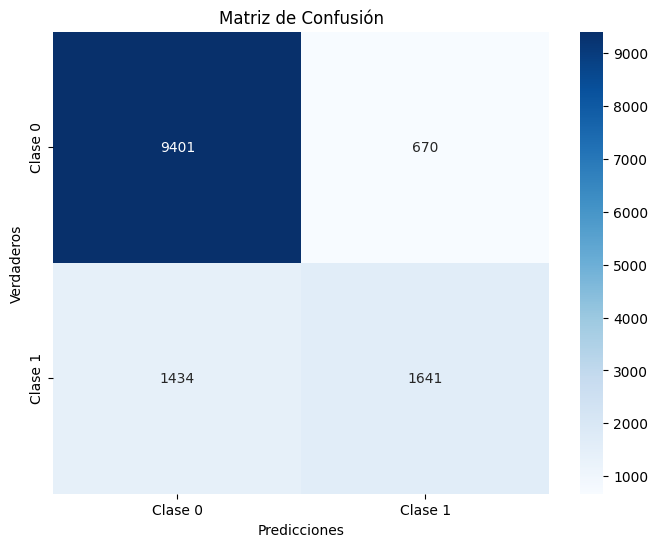

In [429]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

- **Precisión para Clase 0 (No va a llover):** El modelo es mucho más preciso prediciendo la Clase 0 (9401 predicciones correctas vs. 670 incorrectas).
- **Precisión para Clase 1 (Va a llover):** El modelo tiene más dificultad prediciendo la Clase 1 (1641 correctas vs. 1434 incorrectas).
  
Esto indica que el modelo tiene un mejor rendimiento para la Clase 0, pero tiene problemas con la Clase 1.

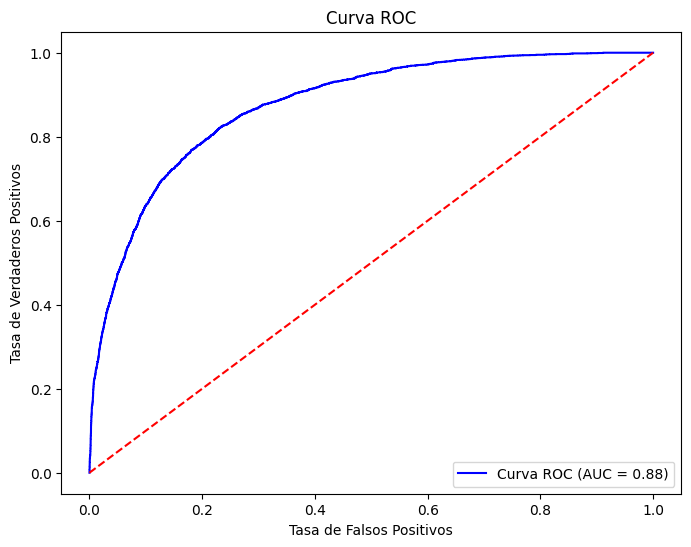

Mejor umbral: 0.20


In [430]:
# Cálculo de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Encontrar el mejor umbral
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Mejor umbral: {optimal_threshold:.2f}")


- Trazamos la curva ROC para el modelo, y la AUC fue de aproximadamente 0.88, lo que indica que el modelo tiene una buena capacidad para diferenciar entre las clases.  
- Calculamos el mejor umbral, que resultó ser **0.20**, lo que significa que para predecir lluvia, el modelo requiere una probabilidad de al menos **0.20**.

#### **Evaluación del Fitting**:
- En cuanto al fitting, el modelo tiene una **accuracy** de **0.84**, lo que refleja un rendimiento general sólido. Sin embargo, presenta una **precision** de **0.71** y un **recall** de **0.53**. Esto sugiere que el modelo predice correctamente la clase positiva en el 71% de los casos, pero le falta capturar una proporción más alta de días lluviosos.
- El **F1 Score** de **0.61** refuerza la idea de que hay un equilibrio moderado entre precision y recall, pero aún queda espacio para mejorar en la detección de días lluviosos.
- La matriz de confusión indica un número considerable de falsos negativos, lo que confirma que el modelo no está completamente ajustado para predecir de manera precisa la clase positiva (días lluviosos).
- En general, aunque el modelo ofrece una buena accuracy, el bajo recall y los falsos negativos sugieren que aún necesita mejoras para predecir con mayor fiabilidad los días con lluvia.


## Modelo Base

Para nuestro modelo base decidimos utilizar el DummyClassifier con la estrategia "stratified".

In [431]:
# Inicializar el DummyClassifier con la estrategia 'stratified'
dummy_clf_stratified = DummyClassifier(strategy='stratified', random_state=42)

# Entrenar el modelo Dummy
dummy_clf_stratified.fit(X_train, y_train)

# Predecir probabilidades en lugar de clases
y_pred_dummy_proba = dummy_clf_stratified.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva



In [432]:
# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred_dummy_proba)
precision = precision_score(y_test, y_pred_dummy_proba)
recall = recall_score(y_test, y_pred_dummy_proba)
f1 = f1_score(y_test, y_pred_dummy_proba)

# Mostrar las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.65
Precision: 0.25
Recall: 0.24
F1 Score: 0.25


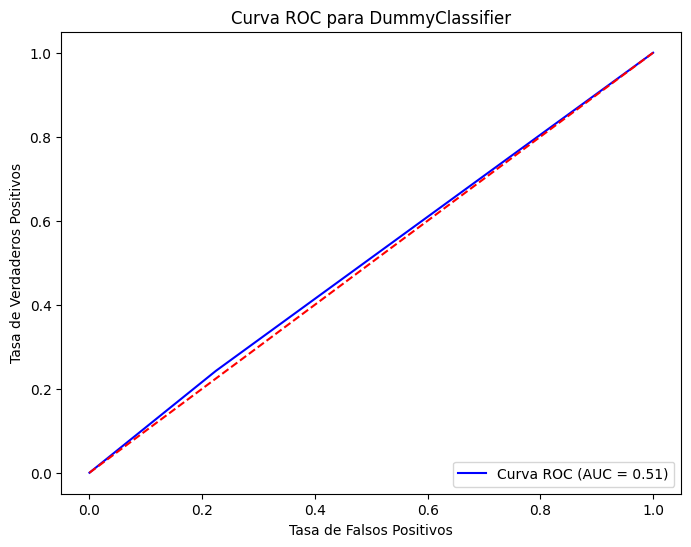

Mejor umbral: 1.00


In [433]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dummy_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para DummyClassifier')
plt.legend(loc='lower right')
plt.show()

# Encontrar el mejor umbral
optimal_idx = np.argmax(tpr - fpr)  # Mejor umbral donde TPR - FPR es máximo
optimal_threshold = thresholds[optimal_idx]

print(f"Mejor umbral: {optimal_threshold:.2f}")

**Análisis del DummyClassifier**:

Viendo los resultados, podemos considerar al **DummyClassifier** como un punto de referencia, aunque proporciona un rendimiento limitado en este contexto. El modelo tiene un **AUC de 0.51**, lo que indica que su capacidad para distinguir entre las clases es prácticamente aleatoria. Además, con un umbral de **1.00**, el modelo resulta ineficaz para predecir la lluvia.

Aunque el modelo muestra una **accuracy** del **65%**, las métricas de **precision** (**0.25**), **recall** (**0.24**), y **F1 Score** (**0.25**) son bajas. Esto nos dice que el modelo no está capturando adecuadamente los días lluviosos. 

Para mejorar la capacidad predictiva, necesitamos aplicar modelos más sofisticados que manejen mejor el desbalance entre clases y que puedan proporcionar resultados más útiles para este tipo de trabajos.
